# Proyecto Inteligencia Artificial
### Stefano Aragoni
### Luis Diego Santos
### Carol Arevalo

#### El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

### Task 1.0: Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [12]:
#importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [13]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets.csv')

# Imprimir las primeras 5 filas
data.head()

# Imprimir las últimas 5 filas
data.tail()

#imprimir la cantidad de filas y columnas
data.shape

(47692, 2)

##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

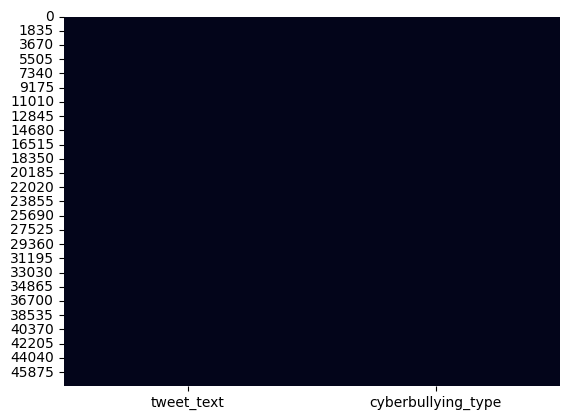

In [14]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [15]:
#verificar datos duplicados
data.duplicated().sum()

36

In [16]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [19]:
#distriubución de los datos
data.describe()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


In [20]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


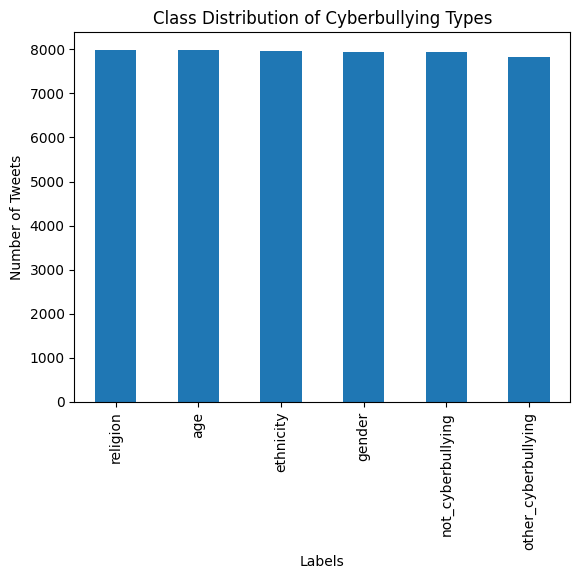

In [22]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()